# Session 5: Running Iteratively

Running Source models from Python becomes more compelling when you start running the model multiple times, modifying something (parameters, inputs, structure) about the model between runs.

At the same time, the number of possible actions expands, and in many cases there are multiple possible ways to achieve a particular change.

This session explores iterative runs and some of the ways to make changes to the Source model.

In this session, the changes will be 'non-structural' - which is a loose term, but here it means that we won't be adding or removing nodes, links or catchments and we won't be changing model types within the network.

The types of non-structural changes we will cover include:

* Iterating over input sets
* Modifying functions
* Modifying time series, piecewise linear functions, etc
* Modifying input sets
* Modifying variables directly

## Overview

- Organising batch runs
  - Hard code in the notebook
  - Externalise into a separate file?
  - Move logic to Python modules?
- Batch Runs
  - Over pre-defined input sets
  - Modifying functions
  - Modifying time series, piecewise linear functions, etc
  - Modifying input sets
  - Modifying variables directly
- Querying and summarising results

## Aside: Organising Batch Runs

The functionality covered in this session is enough to create some quite sophisticated modelling workflows.

_It is worth considering how you organise such workflows._

Notebooks can be useful and important documentation regarding your modelling. The notebooks are a way to make your actions reproducible, both by others in the future and on other Source models.

When moving to more sophisticated notebooks, it is worth considering the following issues:

* Where will you store data that is related to the model runs - such as the set of parameter values you iterate over, and
* How much of the logic will you keep in the notebook - is it worth moving logic out into separate .py modules that can be used by multiple notebooks.

In order to be standalone, these tutorial notebooks tend to combine all the data and logic into the notebook itself, but this isn't desirable. In some cases, it is worth extracting the data into files so that the notebook can be run in other circumstances with different data. In other cases, there is enough custom logic in the workflow that this logic should be in Python modules in order to facilitate reuse.


**We'll mostly take the easy route in these tutorials - and keep it all the notebook.**






## Which Model?

**Note:** This session uses `ExampleProject/RiverModel2.rsproj`. You are welcome to work with your own model instead, however you will need to change the notebook text at certain points to reflect the names of nodes, links and functions in your model file.


## Iterating over Input Sets

Perhaps the simplest approach to iterating with Python and Source is to the run the model for a series of Scenario Input Sets, where you've separately defined those input sets - eg manually.

There are two main ways to use input sets in batch runs:

1. Specify an input set for each simulation when calling `v.run_model`. This instructs Source to use that Input Set include all data sources configured for that Input Set.
2. Call `v.apply_input_set` before `v.run_model`. `v.apply_input_set` will only execute the parameter 'instructions' in the input set.

Option 2 can be useful where you have numerous input sets that need to be combined in various ways for different scenarios.

Here, we will demonstrate option 1 (specify in `v.run_model()`) and then illustrate option 2 with a hypothetical example (which has a basis in reality!).

### As always, initialise the Veneer client

As always, you need to have the veneer package imported and a Veneer client object created

In [1]:
import veneer
v = veneer.Veneer(port=9876)

### Finding the input sets in the model

We can find the input sets in the current model with `v.input_sets()`

In [2]:
input_sets = v.input_sets()
input_sets

[{'Name': 'Unrestricted Take', 'URL': '/inputSets/Unrestricted Take', 'Filename': None, 'Configuration': ['Nodes.Supply Point 13.Maximum Extraction Rate = 100000 ML/d'], 'ReloadOnRun': False}, {'Name': 'Default Input Set', 'URL': '/inputSets/Default Input Set', 'Filename': None, 'Configuration': [], 'ReloadOnRun': False}]

In [3]:
input_sets.as_dataframe()

,Configuration,Filename,Name,ReloadOnRun,URL
0,[Nodes.Supply Point 13.Maximum Extraction Rate...,None,Unrestricted Take,False,/inputSets/Unrestricted Take
1,[],None,Default Input Set,False,/inputSets/Default Input Set


**Note:** When looking at the details of the input set from Python, you only see the instructions (under `Configuration`). This is because the instructions are the only thing that you can easily modify from Python at this stage. Everything else is there in Source and will be used when you run the model.



We can iterate over the `input_sets` list using a Python `for` loop, but first, we should establish a way to track the results we are interested in.

The input sets in the sample model simply change the maximum extraction rate at the supply point. The effect of this should be visible at a few points in the model - in terms of storage releases, extractions, shortfalls on the demand and flow out the bottom of the system. Lets ensure we are recording some of those

In [4]:
things_to_record=[
    {'NetworkElement':'Lower Gauge','RecordingVariable':'Downstream Flow Volume'},
    {'NetworkElement':'Crop Fields'},
    {'NetworkElement':'Recreational Lake','RecordingElement':'StorageVolume'}
]

v.configure_recording(enable=things_to_record)

We now want to iterate over the input sets, running the model each time, and retrieving some results for each run.

We can either:

1. do all the runs and retrieve all the results after all the runs, OR
2. do one run at a time and retrieve the relevant results.

Option 2 allows us to drop each run as we go (which can be useful to save memory on big models).

Either way, we need to track information as we go - with option 1 we need to know which run relates to each input set.

We will use a Python dictionary to let us track `input set` -> `results time series`

In [5]:
all_results = {}

A python `for` loop takes the form

```python
for element in loop_range:
  do_something_typically_using(element)
```

where `loop_range` is the thing you're looping over and is typically a list or similar. (It needs to be 'iterable')

For example:

In [6]:
for i in [0,1,2,3,4]:
    print(i)

0
1
2
3
4


There are lots of ways to support loop writing, such as the `range(n)` function, which returns an iterable object that goes from 0 to n-1:

In [7]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


We will loop over the `input_sets` list, where each item in the list is a Python dictionary. Those dictionaries contain the `'Name'` key, which we need to pass to Source

We need some help from the pandas core library for this one (to combine DataFrames from two calls to `v.retrieve_multiple_time_series`), so we'll import it here

In [8]:
import pandas as pd

In [9]:
for input_set in input_sets:
    set_name = input_set['Name']
    # Log what's happening
    veneer.log('Running ' + set_name)
    
    # Run the model with the current input set
    v.run_model(SelectedInputSet=set_name)
    
    # Retrieve the run index so we can pass it to v.retrieve_multiple_time_series
    run_index = v.retrieve_run()
    
    # Now, retrieve the results we want
    end_of_system_flow = v.retrieve_multiple_time_series(run_data=run_index,criteria={
            'NetworkElement':'Lower Gauge','RecordingVariable':'Downstream Flow Volume'
        })
    
    crop_time_series = v.retrieve_multiple_time_series(run_data=run_index,criteria={
            'NetworkElement':'Crop Fields','RecordingVariable':'.*@Demand Model@.*'
        })
    
    all_results[set_name] = pd.merge(end_of_system_flow,crop_time_series,left_index=True,right_index=True)
    

Running Unrestricted Take
Running Default Input Set


Now that that's run, lets look at the results

The default view won't be that friendly...

In [10]:
all_results

{'Default Input Set':             Lower Gauge:Downstream Flow Volume  \
 1998-01-11                        0.000000e+00   
 1998-01-12                        0.000000e+00   
 1998-01-13                        0.000000e+00   
 1998-01-14                        0.000000e+00   
 1998-01-15                        0.000000e+00   
 1998-01-16                        0.000000e+00   
 1998-01-17                        0.000000e+00   
 1998-01-18                        0.000000e+00   
 1998-01-19                        0.000000e+00   
 1998-01-20                        0.000000e+00   
 1998-01-21                        0.000000e+00   
 1998-01-22                        0.000000e+00   
 1998-01-23                        0.000000e+00   
 1998-01-24                        0.000000e+00   
 1998-01-25                        0.000000e+00   
 1998-01-26                        0.000000e+00   
 1998-01-27                        0.000000e+00   
 1998-01-28                        0.000000e+00   
 1998-01-2

but we can pick the results for a given input set. 

In [11]:
all_results['Default Input Set'][0:10]

,Lower Gauge:Downstream Flow Volume,Crop Fields:Demand & Storage Interface@Demand Model@Opportunistic Requiremements,Crop Fields:Demand & Storage Interface@Demand Model@Opportunistic Water Supplied,Crop Fields:Demand & Storage Interface@Demand Model@Regulated Requirements,Crop Fields:Demand & Storage Interface@Demand Model@Regulated Water Supplied,Crop Fields:Demand & Storage Interface@Demand Model@Total Water Supplied
1998-01-11,0.0,0,0,44275.0,0.0,0.0
1998-01-12,0.0,0,0,48875.0,0.0,0.0
1998-01-13,0.0,0,0,58650.0,0.0,0.0
1998-01-14,0.0,0,0,96600.0,0.0,0.0
1998-01-15,0.0,0,0,44850.0,0.0,0.0
1998-01-16,0.0,0,0,36800.0,0.0,0.0
1998-01-17,0.0,0,0,55200.0,0.0,0.0
1998-01-18,0.0,0,0,13800.0,0.0,0.0
1998-01-19,0.0,0,0,24725.0,0.0,0.0
1998-01-20,0.0,0,0,21850.0,0.0,0.0


Note how the results from two calls to `v.retrieve_multiple_time_series` have been combined into the one DataFrame

Lets enable charting now so we can plot them

(This time, we explicitly import `matplotlib.pyplot` in order to get the `legend` function)

In [12]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


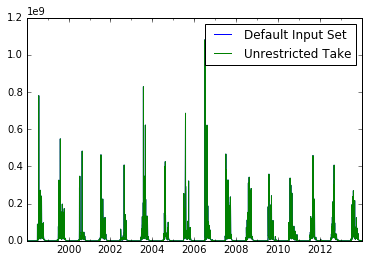

In [13]:
for input_set in all_results:
    all_results[input_set]['Lower Gauge:Downstream Flow Volume'].plot(label=input_set)
plt.legend()

There's obviously no visible difference there...

Lets compute the difference between the two runs and see if we can find deltas


In [14]:
delta = all_results['Default Input Set']-all_results['Unrestricted Take']
delta

,Lower Gauge:Downstream Flow Volume,Crop Fields:Demand & Storage Interface@Demand Model@Opportunistic Requiremements,Crop Fields:Demand & Storage Interface@Demand Model@Opportunistic Water Supplied,Crop Fields:Demand & Storage Interface@Demand Model@Regulated Requirements,Crop Fields:Demand & Storage Interface@Demand Model@Regulated Water Supplied,Crop Fields:Demand & Storage Interface@Demand Model@Total Water Supplied
1998-01-11,0.0,0,0,0.0,0.0,0.0
1998-01-12,0.0,0,0,0.0,0.0,0.0
1998-01-13,0.0,0,0,0.0,0.0,0.0
1998-01-14,0.0,0,0,0.0,0.0,0.0
1998-01-15,0.0,0,0,0.0,0.0,0.0
1998-01-16,0.0,0,0,0.0,0.0,0.0
1998-01-17,0.0,0,0,0.0,0.0,0.0
1998-01-18,0.0,0,0,0.0,0.0,0.0
1998-01-19,0.0,0,0,0.0,0.0,0.0
1998-01-20,0.0,0,0,0.0,0.0,0.0


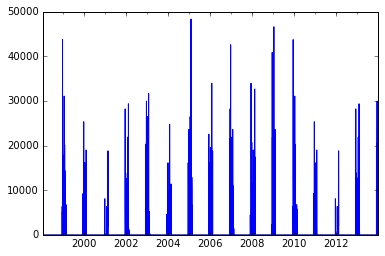

In [15]:
delta['Lower Gauge:Downstream Flow Volume'].plot()

So there is a difference, albeit small c.f. the overall system flow.

### Assembling scenarios from multiple input sets

In a recent project, there was a requirement to run 48 simulations. This was made up of 12 development scenarios x 4 climate scenarios.

The scenarios were described as input sets:

* 4 input sets each described one of the climate scenarios
* 8 input sets described the 12 scenarios, by combining the 8 input sets in different ways and using `v.apply_input_sets` in a particular order.

The scenario runs were organised as follows:

* Each scenario was described as a list of input sets that needed to be applied, including the order
* The different scenarios were grouped together in a dictionary with the overall name of the scenario:

```python
scenarios={
  'Baseline':['Reset Input Set'],
  'Development Case 1':['Reset Input Set','Increase Crop Areas'],
  'Development Case 2':['Reset Input Set','Increase Crop Areas','Increase Storage Volumes'],
}
```

While the climate input sets were identifed by the input set name:

```python
climate_sets=['Historic','Low Rainfall','Moderate Rainfall','High Rainfall']
```

The model runs were then handled with a nested loop:

```python
for scenario_name,input_sets in scenarios.items:

  # Run the input sets required by this scenario
  for scenario_input_set in input_sets:
    v.apply_input_set(scenario_input_set)

  # Run the model in this configuration, once for each climate input set
  for climate_set in climate_sets:
    v.run_model(SelectedInputSet=climate_set)
```


**Note:** Source will remember the last input set used as the `SelectedInputSet`. If you want to use a different input set for the next run, you will need to explicitly specify it on the next call to `v.run_model()`


## Aside: Changes (usually) persist!

In the above examples, and in most (but not all!) of what follows, when you specify a change for a particular run, that change will persist - ie it will still be there in future runs unless you change things back.

In some cases, the changes will get saved in the model file.

There is no generic 'undo' functionality in Veneer or veneer-py, so you need to consider how you reset any changes that you don't want to keep. For example:

* Just don't save the model if you don't want the changes to be permanent. In many cases this is the simplest approach - simply write the script to take a working model, run some analyses and then close the software.
* Query values before modifying them. This way, you can save the initial setup in a variable in Python and use it to reset later.
* Have a 'reset' input set that covers all the things you'll be modifying. Execute this input set with `v.apply_input_set` when reset is required

The flipside is that _not all changes_ will persist, even if you want them to. Most notably, changes to a the time series data in a data source won't be saved back to disk. Changed time series will survive as long as the project is open in the current session of Source.

## Modifying functions

The Functions feature in Source was the initial way in which model parameters could be expossed to external programs, through `RiverSystem.CommandLine`.

You can query and modify functions in Source. While you can do this for any Function, its typical to define Functions that are scalars, and modify these, with the scalar functions being referenced by other functions.

This can be seen in the sample model.

In [16]:

functions = v.functions()
f_df = functions.as_dataframe()
f_df

,Expression,Name
0,1.0,$InflowScaling
1,$InflowScaling*$CrabTS,$CrabScaled
2,$InflowScaling*$FishTS,$FishScaled
3,$InflowScaling*$ShellTS,$ShellScaled
4,"lookup($PatternPW,$Now.DayOfYear)",$MinFlow


**Note:** Jupyter thinks those expressions are in LaTeX format. We'll temporarily disable HTML output to look at this data frame

In [17]:
print(f_df)

                          Expression            Name
0                                1.0  $InflowScaling
1             $InflowScaling*$CrabTS     $CrabScaled
2             $InflowScaling*$FishTS     $FishScaled
3            $InflowScaling*$ShellTS    $ShellScaled
4  lookup($PatternPW,$Now.DayOfYear)        $MinFlow


We can see that `$InflowScaling` is used by three functions - `$CrabSaled`, `$FishScaled` and `$ShellScaled`. These functions are used to scale the respective inflow timeseries by a single scaling factor.

We can use `$InflowScaling` to scale all model inflows, for example to test the reliability of the system under reduced inflow.

In [18]:
v.update_function('$InflowScaling',0.5)

(200, None)

In [19]:
print(v.functions().as_dataframe())

                          Expression            Name
0                                0.5  $InflowScaling
1             $InflowScaling*$CrabTS     $CrabScaled
2             $InflowScaling*$FishTS     $FishScaled
3            $InflowScaling*$ShellTS    $ShellScaled
4  lookup($PatternPW,$Now.DayOfYear)        $MinFlow


_Before proceeding, lets reset `$InflowScaling` to its original value_

Because its just one change, its easy enough to hard code it here...

In [20]:
v.update_function('$InflowScaling',1.0)

(200, None)

Alternatively, we could reset all the functions to the values we retrieved earlier.

`functions` is a list of Python dictionaries, with each dictionary in the list having a `'Name'` and the the expression

In [21]:
for fn in functions:
    v.update_function(fn['Name'],fn['Expression'])

### Batch run using functions

We can now run a number of runs, modifying the `$InflowScaling` function each time and hence modifying the system inflow time series.

We'll perform a very simple (and short!) monte-carlo simulation, sampling from the exponential distribution. We'll then see what effect this has on spill volumes from the storage.

The random generators for different distributions are in the `numpy` package, which, by convention, is imported as `np`

In [22]:
import numpy as np

In [23]:
NUMBER_OF_SIMULATIONS=50
sampled_scaling_factors = np.random.exponential(size=NUMBER_OF_SIMULATIONS) 
sampled_scaling_factors

array([ 1.9621639 ,  0.44257839,  2.90745774,  0.11849386,  2.56311462,
        0.01295068,  1.83925184,  0.40649689,  5.50482885,  1.1853694 ,
        0.54357019,  1.24888575,  0.23689105,  0.52260336,  0.19151876,
        0.52020148,  3.01206095,  2.35190245,  0.28014042,  1.6314588 ,
        1.11797425,  0.03908908,  5.23394566,  2.14908792,  1.3494156 ,
        0.19228859,  1.73949871,  0.37995074,  0.33013762,  1.54171428,
        0.10185547,  1.33453277,  2.49221331,  1.32086468,  0.8424739 ,
        0.42131055,  1.32224825,  0.32623494,  4.69354184,  0.16707846,
        1.12729944,  0.3527046 ,  0.04074066,  2.32081883,  0.92881553,
        0.62926993,  0.27589854,  2.34757877,  0.75978305,  1.05174625])

(array([ 21.,   5.,  10.,   4.,   5.,   2.,   0.,   0.,   1.,   2.]),
 array([ 0.01295068,  0.5621385 ,  1.11132632,  1.66051413,  2.20970195,
         2.75888977,  3.30807758,  3.8572654 ,  4.40645322,  4.95564103,
         5.50482885]),
 <a list of 10 Patch objects>)

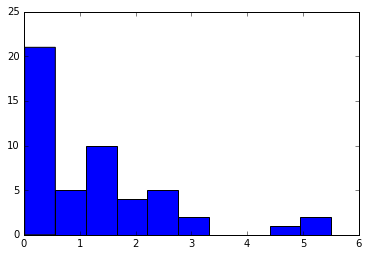

In [24]:
plt.hist(sampled_scaling_factors)

Now we can construct our loop and gather the results.

I only want numbers on the average spill for each run, and I want to be able to plot it as a distribution in much the same way that we've plotting the distribution of `$InflowScaling`

In [25]:
spill_results=[]

# Store our time series criteria in a variable to use it in configuring recording and retrieving results
ts_match_criteria = {'NetworkElement':'Recreational Lake','RecordingVariable':'Spill Volume'}

v.configure_recording(enable=[ts_match_criteria])

for scaling_factor in sampled_scaling_factors:
    veneer.log('Running for $InflowScaling=%f'%scaling_factor)

    # We are running the multiple many times in this case - so lets drop any results we already have...
    v.drop_all_runs()

    # Set $InflowScaling to current scaling factor
    v.update_function('$InflowScaling',scaling_factor)
    v.run_model()
    
    # Retrieve the spill time series, as an annual sum, with the column named for the variable ('Spill Volume')
    run_results = v.retrieve_multiple_time_series(criteria=ts_match_criteria,timestep='annual',name_fn=veneer.name_for_variable)
    
    # Store the mean spill volume and the scaling factor we used
    spill_results.append({'ScalingFactor':scaling_factor,'SpillVolume':run_results['Spill Volume'].mean()})

# Convert the results to a Data Frame
spill_results_df = pd.DataFrame(spill_results)
spill_results_df

Running for $InflowScaling=1.962164
Running for $InflowScaling=0.442578
Running for $InflowScaling=2.907458
Running for $InflowScaling=0.118494
Running for $InflowScaling=2.563115
Running for $InflowScaling=0.012951
Running for $InflowScaling=1.839252
Running for $InflowScaling=0.406497
Running for $InflowScaling=5.504829
Running for $InflowScaling=1.185369
Running for $InflowScaling=0.543570
Running for $InflowScaling=1.248886
Running for $InflowScaling=0.236891
Running for $InflowScaling=0.522603
Running for $InflowScaling=0.191519
Running for $InflowScaling=0.520201
Running for $InflowScaling=3.012061
Running for $InflowScaling=2.351902
Running for $InflowScaling=0.280140
Running for $InflowScaling=1.631459
Running for $InflowScaling=1.117974
Running for $InflowScaling=0.039089
Running for $InflowScaling=5.233946
Running for $InflowScaling=2.149088
Running for $InflowScaling=1.349416
Running for $InflowScaling=0.192289
Running for $InflowScaling=1.739499
Running for $InflowScaling=0

,ScalingFactor,SpillVolume
0,1.962164,1.032165e+10
1,0.442578,2.156053e+09
2,2.907458,1.544353e+10
3,0.118494,4.721928e+08
4,2.563115,1.357607e+10
5,0.012951,1.667945e+07
6,1.839252,9.657013e+09
7,0.406497,1.965273e+09
8,5.504829,2.956858e+10
9,1.185369,6.129625e+09


**Notes:**

* When retrieving the time series, we retrieved annual time series. When running locally, this is probably only for convenience. If you were running Python and Source on different computers, retrieving monthly or annual results can improve performance by reducing network traffic.
* The units are again m^3/year - a fact we could check if we ran a single run and looked at the attributes on the time series. For now, we'll just convert them to GL
* The call to `v.drop_all_runs()` ensures that we don't have 50 full results sets sitting in memory. By dropping the runs at the start of the loop, before running the model, we ensure that we have one set of results at the end in case we need to investigate anything in more detail.

In [26]:
spill_results_df['SpillVolumeGL'] = spill_results_df['SpillVolume'] * 1e-6 # Convert to GL

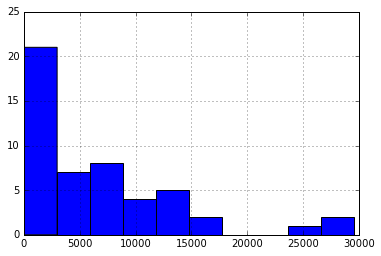

In [27]:
spill_results_df['SpillVolumeGL'].hist()

## Modifying time series and piecewise linear functions

Functions in Source can make use of numerous types of _variables_, which can derive values from a number of sources, including:

* values within the model, such as state variables,
* time series inputs (data sources),
* piecewise linear functions,
* time varying patterns.

You can query Source for the list of variables, and, at this stage, you can directly modify time series variables and piecewise linear variables.

In [28]:
variables = v.variables()
variables_df = variables.as_dataframe()
variables_df

,FullName,ID,Name,PiecewiseFunction,TimeSeries,VariableType,VeneerDebugInfo,VeneerSupported
0,$PatternPW,77,$PatternPW,/variables/PatternPW/Piecewise,None,LinearVariable,None,True
1,$CrabTS,78,$CrabTS,None,/variables/CrabTS/TimeSeries,TimeSeriesVariable,DisplayName=$CrabTS;ResultUnit=no unit selecte...,True
2,$FishTS,79,$FishTS,None,/variables/FishTS/TimeSeries,TimeSeriesVariable,DisplayName=$FishTS;ResultUnit=no unit selecte...,True
3,$ShellTS,80,$ShellTS,None,/variables/ShellTS/TimeSeries,TimeSeriesVariable,DisplayName=$ShellTS;ResultUnit=no unit select...,True
4,$Now.Day,58,$Day,None,None,NowVariable,None,False
5,$Start.Day,59,$Day,None,None,FixedDateVariable,None,False
6,$End.Day,60,$Day,None,None,FixedDateVariable,None,False
7,$Now.Month,61,$Month,None,None,NowVariable,None,False
8,$Start.Month,62,$Month,None,None,FixedDateVariable,None,False
9,$End.Month,63,$Month,None,None,FixedDateVariable,None,False


This summary doesn't tell you anything about the details of the values in the variable - although in some cases there is a URL pointing to the details (in the `PiecewiseFunction` column or the `TimeSeries` column).

As a quick summary of where more details are available, filter for variables where `VeneerSupported=True`

In [29]:
variables_df[variables_df.VeneerSupported]

,FullName,ID,Name,PiecewiseFunction,TimeSeries,VariableType,VeneerDebugInfo,VeneerSupported
0,$PatternPW,77,$PatternPW,/variables/PatternPW/Piecewise,None,LinearVariable,None,True
1,$CrabTS,78,$CrabTS,None,/variables/CrabTS/TimeSeries,TimeSeriesVariable,DisplayName=$CrabTS;ResultUnit=no unit selecte...,True
2,$FishTS,79,$FishTS,None,/variables/FishTS/TimeSeries,TimeSeriesVariable,DisplayName=$FishTS;ResultUnit=no unit selecte...,True
3,$ShellTS,80,$ShellTS,None,/variables/ShellTS/TimeSeries,TimeSeriesVariable,DisplayName=$ShellTS;ResultUnit=no unit select...,True


We can query for either the piecewise function or the time series

In [30]:
v.variable_piecewise('$PatternPW')

,Lookup,Result
0,0,25
1,60,25
2,61,50
3,180,50
4,181,15
5,270,15
6,271,30
7,366,30


In [31]:
v.variable_time_series('$CrabTS')[::500]

,Value
Date,
1998-01-11,0.000
1999-05-26,0.294
2000-10-07,24.916
2002-02-19,0.578
2003-07-04,314.892
2004-11-15,3.329
2006-03-30,0.399
2007-08-12,59.217
2008-12-24,1.137


We can update a piecewise linear variable by passing an appropriate dataframe (one with two columns, each with numbers) to `v.update_variable_piecewise`

For example, lets double the minimum flow requirement (`$PatternPW`)

In [32]:
pattern = v.variable_piecewise('$PatternPW')
pattern

,Lookup,Result
0,0,25
1,60,25
2,61,50
3,180,50
4,181,15
5,270,15
6,271,30
7,366,30


In [33]:
pattern['Result'] *= 2.0 # Multiply each value of Result column by 2
pattern

,Lookup,Result
0,0,50.0
1,60,50.0
2,61,100.0
3,180,100.0
4,181,30.0
5,270,30.0
6,271,60.0
7,366,60.0


In [34]:
v.update_variable_piecewise('$PatternPW',pattern)

{'XName': 'Lookup', 'Entries': [[0.0, 50.0], [60.0, 50.0], [61.0, 100.0], [180.0, 100.0], [181.0, 30.0], [270.0, 30.0], [271.0, 60.0], [366.0, 60.0]], 'YName': 'Result'}


(200, None)

You can check that the change has taken effect by looking in the Functions Manager in Source, or retrieving the piecewise function again

In [35]:
v.variable_piecewise('$PatternPW')

,Lookup,Result
0,0,50
1,60,50
2,61,100
3,180,100
4,181,30
5,270,30
6,271,60
7,366,60


Updating time series variables works in much the same way - you need to pass a DataFrame with an appropriate structure. In this case, you need a date time index and a single column of values.

One approach is to retrieve the existing time series data then modify the Value column (keeping the date index in place)

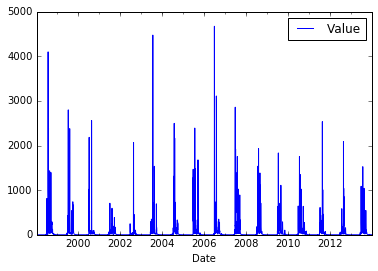

In [36]:
crab_ts = v.variable_time_series('$CrabTS')
crab_ts.plot()

Lets generate a synthetic time series based on the existing sequence.

We'll apply a distinct monthly scaling factor. We could do this in Source through a pattern variable, but using Python is an opportunity to demonstrate some of the time series capabilities in pandas.

First, lets initialise the scaling factor data.

In [37]:
monthly_scaling=[0.6,0.75,1.0,1.0,1.1,1.20,1.20,1.1,1.0,0.8,0.6,0.5]
len(monthly_scaling)

12

In [38]:
scaling_df = pd.DataFrame(data={'Month':range(1,13),'Scale':monthly_scaling}).set_index('Month')
scaling_df

,Scale
Month,
1,0.60
2,0.75
3,1.00
4,1.00
5,1.10
6,1.20
7,1.20
8,1.10
9,1.00


So, now we need to apply these monthly factors to every day in the time series.

In many languages, you would write a loop (eg a `for` loop) at this point.

In Python, and particularly with numpy and pandas, there are more convenient (and performant) options


Because we have a datetime index on the time series, we can easily get a list of the month for each timestep, using `crab_ts.index.month`:

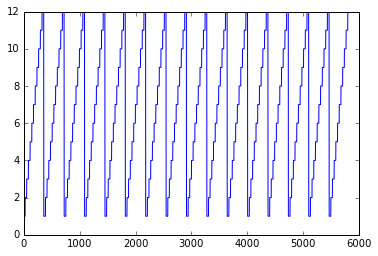

In [39]:
plt.plot(crab_ts.index.month)

So, now we need to take that sequence of values and find the corresponding scaling factors.

We'll use the indexing capabilities of data frames to help. To understand the next step, see what happens when we index `scaling_df` by a month number (starting at 1)

In [40]:
scaling_df.Scale[12]

0.5

Now, see what happens when we provide a series of months (including duplicates)

In [41]:
scaling_df.Scale[[2,5,7,12,12,1]]

Month
2     0.75
5     1.10
7     1.20
12    0.50
12    0.50
1     0.60
Name: Scale, dtype: float64

Extending this, and using the list of months for each timestep, we can find the scaling factor for each timestep

In [42]:
scaling_for_timesteps = scaling_df.Scale[crab_ts.index.month].values

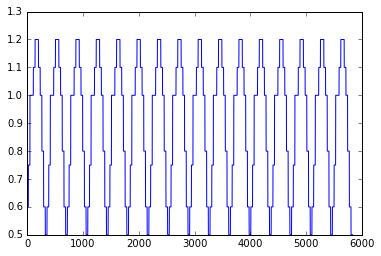

In [43]:
plot(scaling_for_timesteps)

Now, we can multiple the values in the time series by the scaling factors

In [44]:
crab_ts['ValueScaled'] = crab_ts.Value * scaling_for_timesteps

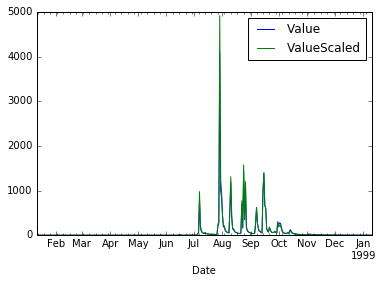

In [45]:
# Lets plot the first year to see the effect
crab_ts[0:365].plot()


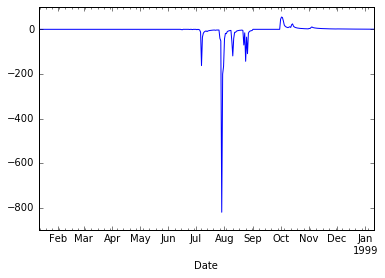

In [46]:
# That's hard to see, so lets look at the difference:
delta = crab_ts.Value-crab_ts.ValueScaled
delta[0:365].plot()

We now have an extra column in our DataFrame. Source is expecting one column for our time series

In [47]:
crab_ts.columns

Index(['Value', 'ValueScaled'], dtype='object')

In [48]:
new_ts = crab_ts[['ValueScaled']]
new_ts[0::500]

,ValueScaled
Date,
1998-01-11,0.0000
1999-05-26,0.3234
2000-10-07,19.9328
2002-02-19,0.4335
2003-07-04,377.8704
2004-11-15,1.9974
2006-03-30,0.3990
2007-08-12,65.1387
2008-12-24,0.5685


In [49]:
v.update_variable_time_series('$CrabTS',new_ts)

(200, None)

## Modifying input sets

At the beginning of this session, we ran a series of scenarios by iterating through each scenario input set and running once for each one.

It is also possible to modify the commands in the input sets themselves.

Modifying input sets gives you control over a great many aspects of the model, although scripting the modification can get a bit fiddly, for two main reasons:

1. You need to manipulate and create Python strings that contain a variable reference (eg `'Nodes.Supply Point 13.Maximum Extraction Rate'`, a value (eg `'100000'`) and units that can be understood by Source (eg `'ML/d'`), and
2. It's hard to work out the variable reference text a priori.

Much of what can be accomplished with input sets can be handled directly using the functions under the `v.model.` namespace. However input sets can be a convenient option for certain parameters that aren't yet well supported under `v.model`. For example, there is currently no way to directly modify the monthly pattern on a minimum flow node, using the functions in veneer-py. However, you can modify the pattern via input sets - and the user interface in Source will give you hints as to how.

1. In the main Source user interface, select Edit|Scenario Input Sets.
2. In the text area where you type commands for the Source model, start typing:
```
Nodes.Lake Release.Monthly Pattern=
```
3. When you pressed `=`, it should show you the current value of the pattern, expressed in the scenario input set syntax. If you select this text and press enter, it should be added to the text editor:
```
Nodes.Lake Release.Monthly Pattern=[0 0 0 0 0 0 0 0 0 0 0 0]{ML/d}
```

You now have a working example of how to set the monthly pattern using an input set - and you can use this, along with Python's string manipulation routines, to set the monthly pattern from Python.

In the following blocks, we will use Python's string handling functionality. A Python tutorial will cover this in more depth.

Lets start by setting up a template for the command to change the monthly pattern. We'll add a string substitution command into the template:

In [50]:
template='Nodes.Lake Release.Monthly Pattern=[%s]{ML/d}'

As you can see, the 0s (separated by spaces) have been replaced with a single `%s`. When used with the string substitution functionality, this tells Python to expect another string that should be inserted at this point.

We'll make that other string contain 12 numbers, separated by spaces.

Lets define the values we want

In [51]:
monthly_values=[5,3,4,6,6,7,7,6,5,4,4,5]

Now, we want to convert our list of numbers (`monthly_values`) to a string, separated by space. We can use the `join` method, available on all strings, to do what we want.

The only trick is that `join` wants a list of strings, not a list of numbers. We'll use a list comprehension to convert each number to a string

In [52]:
list_as_string= ' '.join([str(v) for v in monthly_values])
list_as_string

'5 3 4 6 6 7 7 6 5 4 4 5'

We can now combine this list into the template to create an input set command

In [53]:
command = template%(list_as_string)
command

'Nodes.Lake Release.Monthly Pattern=[5 3 4 6 6 7 7 6 5 4 4 5]{ML/d}'

We can now update an input set of choice by adding this command.

First, retrieve the input sets:

In [54]:
input_sets = v.input_sets()
input_sets.as_dataframe()

,Configuration,Filename,Name,ReloadOnRun,URL
0,[Nodes.Supply Point 13.Maximum Extraction Rate...,None,Unrestricted Take,False,/inputSets/Unrestricted Take
1,[],None,Default Input Set,False,/inputSets/Default Input Set


We'll modify the first one in the list

In [55]:
the_input_set = input_sets[0]
the_input_set['Configuration']

['Nodes.Supply Point 13.Maximum Extraction Rate = 100000 ML/d']

We can use `.append` to add a command to the `'Configuration'`

In [56]:
the_input_set['Configuration'].append(command)
the_input_set['Configuration']

['Nodes.Supply Point 13.Maximum Extraction Rate = 100000 ML/d',
 'Nodes.Lake Release.Monthly Pattern=[5 3 4 6 6 7 7 6 5 4 4 5]{ML/d}']

Now, we can update the input set within Source

In [57]:
v.update_input_set(the_input_set['Name'],the_input_set)

(200, None)

You can check in Source to see that the modified input set has been uploaded.

Now, changing an input set won't have any immediate effect on the model. For the options in the input set to take effect and be visible at (in this case) the minimum flow node, you would need to either:

1. Run the model, with that input set selected,
2. Apply the input set (using `v.apply_input_set` or the option in the Source application)

## Modifying model variables directly

This session has looked at various ways to modify the configuration of the Source model in order to run the model multiple times.

Veneer and veneer-py also include functionality for directly modifying model structure and parameters by executing .NET IronPython scripts within Source itself. This functionality is particularly useful for bulk transformations.

This is the subject of the next session.

